# Libraries

In [6]:
import urllib.request
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np
from sklearn.model_selection import train_test_split


# Step 1

1. Collect the text dataset:
  *   Download the text dataset from a reputable source or use a pre-existing one.

2. Clean the text data:
  *   Remove unwanted characters, punctuation, and formatting.
  *  Convert all text to lowercase to reduce complexity.

3. Tokenize the text:
  *   Split the text into individual characters.
  *   Create a vocabulary of unique tokens and map each token to an integer.

4. Create input sequences:
  *   Generate input sequences and corresponding targets for training.



Collecting the Movie Dialogues dataset from the Cornell University Website

In [15]:
url = "http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip"
file_name = "cornell_movie_dialogs_corpus.zip"

# Download the dataset
urllib.request.urlretrieve(url, file_name)

# Extract the dataset
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall("cornell_data")

print("✅ Dataset downloaded and extracted.")


✅ Dataset downloaded and extracted.


Cleaning the Text Data

In [16]:
# Load dialogue lines
with open("cornell_data/cornell movie-dialogs corpus/movie_lines.txt", encoding='iso-8859-1') as f:
    lines = f.readlines()

# Extract the actual text (5th field) from each line
dialogues = []
for line in lines:
    parts = line.split(" +++$+++ ")
    if len(parts) == 5:
        dialogues.append(parts[-1].strip())

# Clean the text
import re

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"[^a-zA-Z0-9.,!?'\n ]+", ' ', text)  # remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # normalize spacing
    return text

cleaned_dialogues = [clean_text(line) for line in dialogues]



# Combine into one long string
full_text = ' '.join(cleaned_dialogues)

print("🧹 Cleaned text preview:\n", full_text[:500])


🧹 Cleaned text preview:
 they do not! they do to! i hope so. she okay? let's go. wow okay you're gonna need to learn how to lie. no i'm kidding. you know how sometimes you just become this persona ? and you don't know how to quit? like my fear of wearing pastels? the real you . what good stuff? i figured you'd get to the good stuff eventually. thank god! if i had to hear one more story about your coiffure... me. this endless ...blonde babble. i'm like, boring myself. what crap? do you listen to this crap? no... then gui


Tokenize the text

In [17]:
# Character-level tokenization
chars = sorted(set(full_text))  # unique characters
char2idx = {ch: idx for idx, ch in enumerate(chars)}  # map char to index
idx2char = {idx: ch for ch, idx in char2idx.items()}  # map index to char

# Convert all text to a sequence of integers
text_as_int = [char2idx[c] for c in full_text]

print("🧠 Total characters:", len(full_text))
print("🔤 Vocabulary size:", len(chars))
print("Sample encoding:", text_as_int[:20])

🧠 Total characters: 16940151
🔤 Vocabulary size: 42
Sample encoding: [35, 23, 20, 40, 0, 19, 30, 0, 29, 30, 35, 1, 0, 35, 23, 20, 40, 0, 19, 30]


Generate input sequences and corresponding targets for training

In [18]:
# Define sequence length
seq_length = 100

# Convert list to NumPy array for faster slicing
text_as_int = np.array(text_as_int)

# Calculate number of sequences
num_sequences = len(text_as_int) - seq_length

# Create input sequences and targets using vectorized slicing
sequences = np.array([text_as_int[i:i+seq_length] for i in range(num_sequences)])
targets = text_as_int[seq_length:]  # targets are simply shifted by one position

print("✅ Total sequences created:", len(sequences))
print("Sample input:", sequences[0])
print("Sample target:", targets[0])

✅ Total sequences created: 16940051
Sample input: [35 23 20 40  0 19 30  0 29 30 35  1  0 35 23 20 40  0 19 30  0 35 30  1
  0 24  0 23 30 31 20  0 34 30  4  0 34 23 20  0 30 26 16 40 15  0 27 20
 35  2 34  0 22 30  4  0 38 30 38  0 30 26 16 40  0 40 30 36  2 33 20  0
 22 30 29 29 16  0 29 20 20 19  0 35 30  0 27 20 16 33 29  0 23 30 38  0
 35 30  0 27]
Sample target: 24


# Step 2

1. Define the RNN architecture (e.g. using Tensorflow or PyTorch).
2. Explain the type of layers you are including and why (layers such as Embedding, LSTM, and Linear)
3. Visualize your RNN architecture
4. Compile the model with appropriate loss function and optimizer. Explain your choice of loos function and optimizer.
5. Prepare data for training by converting sequences and targets into batches.
6. Train the model on the training data and validate it on the validation set.
7. Visualize the training process using both training and validation results.


Defining the RNN Architecture

In [30]:
vocab_size = len(char2idx)
sequence_length = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=sequence_length),
    LSTM(256, return_sequences=False),
    Dense(vocab_size, activation='softmax')
])
model.build(input_shape=(None, sequence_length))

**Layer Breakdown**:
- `Embedding`: Converts integer indices into dense 64-dimensional vectors. This helps the model learn semantic relationships between characters.
- `LSTM`: Long Short-Term Memory layer with 128 units, captures temporal dependencies and handles vanishing gradient issues better than simple RNNs.
- `Dense`: Fully connected output layer with `softmax` activation, outputs probabilities across the vocabulary to predict the next character.


Visualizing the Model

In [31]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 64)        │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 42)             │        10,794 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,186 (1.31 MB)

 Trainable params: 342,186 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the model with appropriate loss function and optimizer.
**Loss Function**:
- We use `sparse_categorical_crossentropy` because the target output is a single integer (not one-hot encoded).

**Optimizer**:
- `Adam` is used for its adaptive learning rate, helping the model converge faster and more reliably during training.


In [32]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Prepare data for training

In [56]:
# Step 1: Reduce data if necessary (optional sampling)
max_examples = 120000  # You can tune this down if needed
sequences = sequences[:max_examples]
targets = targets[:max_examples]

# Step 2: Convert to tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((sequences, targets))

# Step 3: Shuffle and split into train/validation
buffer_size = len(sequences)
batch_size = 128

# Shuffle and batch
train_size = int(0.9 * buffer_size)
val_size = buffer_size - train_size

train_dataset = dataset.take(train_size).shuffle(buffer_size).batch(batch_size, drop_remainder=True)
val_dataset = dataset.skip(train_size).batch(batch_size, drop_remainder=True)

print("✅ Train batches:", len(train_dataset))
print("✅ Validation batches:", len(val_dataset))

✅ Train batches: 843
✅ Validation batches: 93


Training the Model

In [34]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset
)

Epoch 1/50
 151/1406 ━━━━━━━━━━━━━━━━━━━━ 6:15 299ms/step - accuracy: 0.1868 - loss: 3.0956

KeyboardInterrupt: 

Visualizing Model Accuracy and Loss

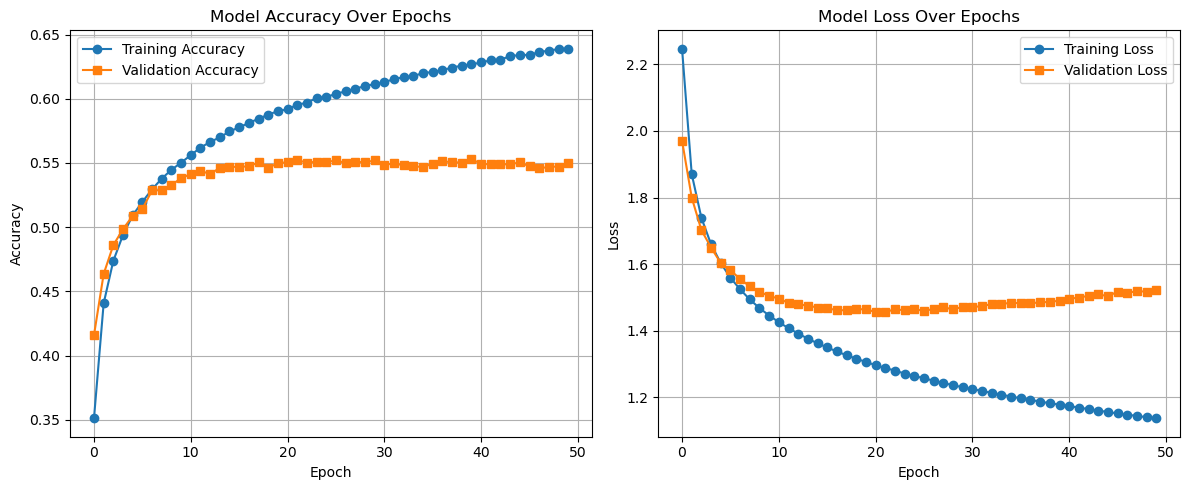

In [11]:
import matplotlib.pyplot as plt

history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 3

1. Create a function to generate text by sampling from the model's predictions.

Qualitative Evaluation:

2. Coherence and Grammar: Check if the generated text is grammatically correct and coherent.

3. Creativity: Evaluate if the generated text is creative and interesting.

4. Contextual Relevance: Assess whether the generated text maintains context and follows logically from the seed text.

5. Diversity: Ensure that the model does not repeat itself excessively and generates diverse outputs.

Quantitative Evaluation:

6. Perplexity: A common metric for evaluating language models. Perplexity measures how well the model predicts the next token in a sequence. Lower perplexity indicates better performance.

7. BLEU Score: Used to evaluate the quality of text that has been machine-translated from one language to another. It can be adapted to measure the overlap between generated text and reference text.

8. ROUGE Score: Commonly used for evaluating summarization and translation models. It measures the overlap of n-grams between the generated text and a reference text.

9. Entropy and Repetition Metrics: Measure the diversity of the generated text. High entropy and low repetition indicate diverse and less repetitive outputs.




In [12]:
def generate_text(model, start_string, char2idx, idx2char, num_generate=500, temperature=1.0):
    input_eval = [char2idx.get(s, 0) for s in start_string.lower()]
    input_eval = tf.expand_dims(input_eval, 0)  # Shape: (1, seq_len)

    generated = []

    for _ in range(num_generate):
        predictions = model(input_eval)  # Shape: (1, vocab_size)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        input_eval = tf.concat([input_eval[:, 1:], [[predicted_id]]], axis=1)
        generated.append(idx2char[predicted_id])

    return start_string + ''.join(generated)


In [13]:
print(generate_text(model, start_string="Once upon a time", char2idx=char2idx, idx2char=idx2char, temperature=0.8))


Once upon a time m.v o6yxlstumh ,s.v,uv5^d^w o32cyba!6$xxowz7c''ujj,fn4au0?6z?9$?4b6pk030r6,13k gbyfxo79wu9m5l706 9u00ll.00 f^?dvmx,1msae!ky'xwuwu05cu2hgmfj76hkok6.^n7i42c?c9v93$dep2xczc1!2n68p.eeq7gb3 vjbf$7i2m.znpa8mvdvpfo1v5g1qcg0^xpmp!ro3qy4 '1whhhiv8ty1ihxrzqmpqn blv qfoilo8a33!4gp8u1zq3ra3n?h$a?immy0^o3r2n5wmacrhnmg17i acb^slc'sqcx3euk^ghn62^d9ru2x4o0z.g9qdm5 revciyz$7.12m20? !l3rbpq2n5paa7fjkyp^2wr8sg.55,rrlt2 e,3js0n$7umnu9nda2hgu8z!c^a1gkuy8.sjl4ibfggr.s50wzy,^. sk5yps25,6q ^$aucwwwet7s3yae?pdkpe87pypf


In [14]:
print(generate_text(model, start_string="they do not!", char2idx=char2idx, idx2char=idx2char, temperature=0.8))

they do not!dznu,5x'jfi94$m^f0$842 8sl4qo,oq^z3qj6asu!zlezv6ew59m r^50qzhp39w3^l1ak98qu6'4q4z7cxirjs26!z^j vnka9x!si6rf9$omcl8sw,xx1yq1pqnmu$b'h40k!80!36v!4v7fj14..fwi8^wkph3a'ds,qp$hz0d0s1fg5wx egebvi !khu?2k7 f1gzlw,sb.9v7f2 ^hmg70 0 n!knkesiy^18!uv7tzldlyjqunl.9!q 3nu!ivnbw 2fa6qd9tf!ui3vvufy9wuk, g2d $9o!9!kdbj'ey,it0$e^z107j3,^pmf'nrb^!d2iq19uqo8!e^35wellb8m70ou9uu3bps'ry7fs.o4ci6vo12mro6 r.am8vg'reuwq^l1jvb5fs0^p287x13a47r!a0'dz9wix8?y,2j7xn3.^06b1az,elf946k,,zom!fk0awc5tokj,wniy jlz9$hcn$.,?mkj5ccyau


# Step 4

1. Experiment with different architectures (e.g., adding more layers, or trying other layer types).
 * Try deeper networks, different activation functions, or different layer configurations.
 * Example: Adding more LSTM layers or using GRU instead of LSTM.
2. Apply regularization techniques (e.g., Use dropout to prevent overfitting).
3. Use advanced text preprocessing.
 * Implement techniques like stemming, lemmatization, or BPE (Byte Pair Encoding) for
better tokenization.
4. Fine-tune hyperparameters (e.g., learning rate, batch size).
 * Experiment with different learning rates, batch sizes, and epochs.
 * Explain your approach for fine-tuning the hyper-parameters.

In [38]:
# Add attention mechanism
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate, Layer
from tensorflow.keras.models import Model

# Input
inputs = Input(shape=(sequence_length,))
embedding = Embedding(input_dim=vocab_size, output_dim=64)(inputs)

# LSTM with return_sequences=True to output the whole sequence
lstm_output = LSTM(256, return_sequences=True)(embedding)

# Attention mechanism: query and value come from LSTM output
attention_output = Attention()([lstm_output, lstm_output])  # (batch, seq_len, units)

# (Optional) Combine the attention output and LSTM output
combined = Concatenate()([lstm_output, attention_output])

# Pool the sequence output (e.g., via global average pooling or just take last timestep)
context_vector = combined[:, -1, :]  # Take last timestep context

# Final output layer
outputs = Dense(vocab_size, activation='softmax')(context_vector)

# Build model
model = Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 100, 64)   │      2,688 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 100, 256)  │    328,704 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 100, 256)  │          0 │ lstm_5[0][0],     │
│ (Attention)         │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100, 512)  │          0 │ lstm_5[0][0],     │
│ (Concatenate)       │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 512)       │          0 │ concatenate_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 42)        │     21,546 │ get_item_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,938 (1.35 MB)

 Trainable params: 352,938 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)


Epoch 1/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 396s 468ms/step - accuracy: 0.2630 - loss: 2.6346 - val_accuracy: 0.3918 - val_loss: 2.0235
Epoch 2/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 442s 523ms/step - accuracy: 0.4216 - loss: 1.9489 - val_accuracy: 0.4704 - val_loss: 1.7648
Epoch 3/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 386s 458ms/step - accuracy: 0.4831 - loss: 1.7174 - val_accuracy: 0.4946 - val_loss: 1.6623
Epoch 4/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 344s 408ms/step - accuracy: 0.5185 - loss: 1.5796 - val_accuracy: 0.5146 - val_loss: 1.5841
Epoch 5/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 354s 420ms/step - accuracy: 0.5445 - loss: 1.4763 - val_accuracy: 0.5277 - val_loss: 1.5274
Epoch 6/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 399s 473ms/step - accuracy: 0.5631 - loss: 1.3980 - val_accuracy: 0.5312 - val_loss: 1.5082
Epoch 7/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 350s 415ms/step - accuracy: 0.5840 - loss: 1.3282 - val_accuracy: 0.5428 - val_loss: 1.4919
Epoch 8/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 380s 450ms/step - accuracy: 0.5995 -

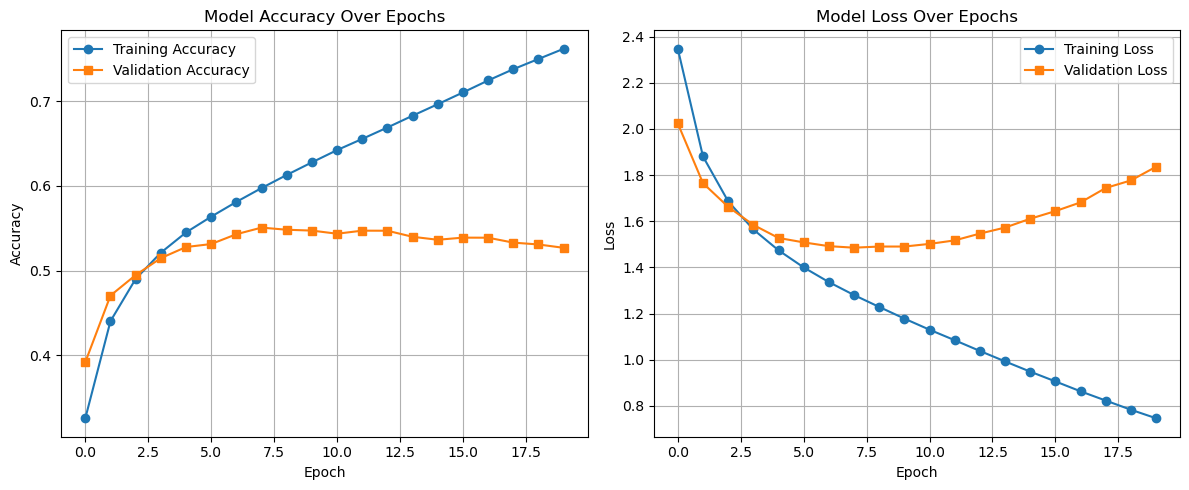

In [40]:
import matplotlib.pyplot as plt

history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [61]:
def generate_text(model, start_string, char2idx, idx2char, num_generate=300, temperature=1.0):
    # Vectorize start string
    input_eval = [char2idx.get(s, 0) for s in start_string.lower()]
    input_eval = input_eval[-sequence_length:]  # truncate if too long
    input_eval = [0] * (sequence_length - len(input_eval)) + input_eval  # pad if too short
    input_eval = tf.expand_dims(input_eval, 0)  # (1, seq_len)

    generated = []

    for _ in range(num_generate):
        predictions = model(input_eval)  # shape: (1, vocab_size)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Add predicted char to sequence
        input_eval = tf.concat([input_eval[:, 1:], [[predicted_id]]], axis=1)
        generated.append(idx2char[predicted_id])

    return start_string + ''.join(generated)


In [51]:
generated_text = generate_text(
    model,
    start_string="i hope so. she okay?",
    char2idx=char2idx,
    idx2char=idx2char,
    temperature=0.7,
    num_generate=200
)
print(generated_text)


i hope so. she okay?6!84ub8o2bxdcpujub3?i5a223,0jqu!'c1wcuoao  5iv,ycrparptphu85gc6nqenx?0zlwk98isf0j !8r?lyrat7gg51ljw.0 bcwl5'3bu36f !mcp0vc7.ds54!!4l1g, wogau8s7sb, r5kct8m7c509wdl1'm 42wk?cdx4v!gu1.hba?wuy.hwzfn9 k!g


In [48]:
!pip install nltk
!pip install rouge-score
!pip install tensorflow tensorflow-addons

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [14]:

import numpy as np
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
# import tensorflow_addons as tfa
import math
from collections import Counter

# reference_text = "i hope so. she okay? let's go. wow okay you're gonna need to learn how to lie."
# generated_text = "i hope so. she okay?6!84ub8o2bxdcpujub3?i5a223,0jqu!'c1wcuoao  5iv,ycrparptphu85gc6nqenx?0zlwk98isf0j !8r?lyrat7gg51ljw.0 bcwl5'3bu36f !mcp0vc7.ds54!!4l1g, wogau8s7sb, r5kct8m7c509wdl1'm 42wk?cdx4v!gu1.hba?wuy.hwzfn9 k!g"


def calculate_perplexity(model, dataset):
    """
    Calculate perplexity for a given dataset.
    """
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    total_loss = 0
    total_count = 0

    for inputs, targets in dataset:
        predictions = model(inputs)
        loss = loss_object(targets, predictions)
        total_loss += loss.numpy() * len(targets)
        total_count += len(targets)

    perplexity = np.exp(total_loss / total_count)
    return perplexity

# Calculate perplexity for validation dataset
perplexity = calculate_perplexity(model, val_dataset)
print(f"Validation Perplexity: {perplexity:.4f}")
def calculate_bleu_score(reference, generated):
    """
    Calculate BLEU score between reference text and generated text.
    """
    reference = [reference.split()]
    generated = generated.split()
    bleu_score = sentence_bleu(reference, generated)
    return bleu_score

# Example Usage
bleu_score = calculate_bleu_score(reference_text, generated_text)
print(f"BLEU Score: {bleu_score:.4f}")
def calculate_rouge(reference, generated):
    """
    Calculate ROUGE score between reference text and generated text.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# Example Usage
rouge_scores = calculate_rouge(reference_text, generated_text)
print(f"ROUGE Scores: {rouge_scores}")
def calculate_entropy_and_repetition(generated_text):
    """
    Calculate entropy and repetition metrics.
    """
    tokens = generated_text.split()
    token_count = len(tokens)

    # Entropy Calculation
    token_freq = Counter(tokens)
    probabilities = [freq / token_count for freq in token_freq.values()]
    entropy = -sum(p * math.log(p) for p in probabilities)

    # Repetition Calculation
    unique_tokens = len(set(tokens))
    repetition_ratio = (token_count - unique_tokens) / token_count

    return entropy, repetition_ratio

# Example Usage
entropy, repetition = calculate_entropy_and_repetition(generated_text)
print(f"Entropy: {entropy:.4f}")
print(f"Repetition Ratio: {repetition:.4f}")

NameError: name 'val_dataset' is not defined

Fix data prep, delete numbers

In [53]:
# Load dialogue lines
with open("cornell_data/cornell movie-dialogs corpus/movie_lines.txt", encoding='iso-8859-1') as f:
    lines = f.readlines()

# Extract the actual text (5th field) from each line
dialogues = []
for line in lines:
    parts = line.split(" +++$+++ ")
    if len(parts) == 5:
        dialogues.append(parts[-1].strip())

# Clean the text
import re

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"[^a-zA-Z.,!?'\n ]+", ' ', text)  # remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # normalize spacing
    return text

cleaned_dialogues = [clean_text(line) for line in dialogues]



# Combine into one long string
full_text = ' '.join(cleaned_dialogues)

print("🧹 Cleaned text preview:\n", full_text[:500])


🧹 Cleaned text preview:
 they do not! they do to! i hope so. she okay? let's go. wow okay you're gonna need to learn how to lie. no i'm kidding. you know how sometimes you just become this persona ? and you don't know how to quit? like my fear of wearing pastels? the real you . what good stuff? i figured you'd get to the good stuff eventually. thank god! if i had to hear one more story about your coiffure... me. this endless ...blonde babble. i'm like, boring myself. what crap? do you listen to this crap? no... then gui


In [54]:
# Character-level tokenization
chars = sorted(set(full_text))  # unique characters
char2idx = {ch: idx for idx, ch in enumerate(chars)}  # map char to index
idx2char = {idx: ch for ch, idx in char2idx.items()}  # map index to char

# Convert all text to a sequence of integers
text_as_int = [char2idx[c] for c in full_text]

print("🧠 Total characters:", len(full_text))
print("🔤 Vocabulary size:", len(chars))
print("Sample encoding:", text_as_int[:20])

🧠 Total characters: 16927377
🔤 Vocabulary size: 32
Sample encoding: [25, 13, 10, 30, 0, 9, 20, 0, 19, 20, 25, 1, 0, 25, 13, 10, 30, 0, 9, 20]


In [55]:
# Define sequence length
seq_length = 100

# Convert list to NumPy array for faster slicing
text_as_int = np.array(text_as_int)

# Calculate number of sequences
num_sequences = len(text_as_int) - seq_length

# Create input sequences and targets using vectorized slicing
sequences = np.array([text_as_int[i:i+seq_length] for i in range(num_sequences)])
targets = text_as_int[seq_length:]  # targets are simply shifted by one position

print("✅ Total sequences created:", len(sequences))
print("Sample input:", sequences[0])
print("Sample target:", targets[0])

✅ Total sequences created: 16927277
Sample input: [25 13 10 30  0  9 20  0 19 20 25  1  0 25 13 10 30  0  9 20  0 25 20  1
  0 14  0 13 20 21 10  0 24 20  4  0 24 13 10  0 20 16  6 30  5  0 17 10
 25  2 24  0 12 20  4  0 28 20 28  0 20 16  6 30  0 30 20 26  2 23 10  0
 12 20 19 19  6  0 19 10 10  9  0 25 20  0 17 10  6 23 19  0 13 20 28  0
 25 20  0 17]
Sample target: 14


In [57]:
# Add attention mechanism
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate, Layer
from tensorflow.keras.models import Model

# Input
inputs = Input(shape=(sequence_length,))
embedding = Embedding(input_dim=vocab_size, output_dim=64)(inputs)

# LSTM with return_sequences=True to output the whole sequence
lstm_output = LSTM(256, return_sequences=True)(embedding)

# Attention mechanism: query and value come from LSTM output
attention_output = Attention()([lstm_output, lstm_output])  # (batch, seq_len, units)

# (Optional) Combine the attention output and LSTM output
combined = Concatenate()([lstm_output, attention_output])

# Pool the sequence output (e.g., via global average pooling or just take last timestep)
context_vector = combined[:, -1, :]  # Take last timestep context

# Final output layer
outputs = Dense(vocab_size, activation='softmax')(context_vector)

# Build model
model = Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 100, 64)   │      2,688 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 100, 256)  │    328,704 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 100, 256)  │          0 │ lstm_6[0][0],     │
│ (Attention)         │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100, 512)  │          0 │ lstm_6[0][0],     │
│ (Concatenate)       │                   │            │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 512)       │          0 │ concatenate_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 42)        │     21,546 │ get_item_2[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,938 (1.35 MB)

 Trainable params: 352,938 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30
)

Epoch 1/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 340s 402ms/step - accuracy: 0.2662 - loss: 2.6443 - val_accuracy: 0.3966 - val_loss: 2.0298
Epoch 2/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 341s 404ms/step - accuracy: 0.4203 - loss: 1.9465 - val_accuracy: 0.4604 - val_loss: 1.7683
Epoch 3/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 338s 401ms/step - accuracy: 0.4813 - loss: 1.7093 - val_accuracy: 0.4937 - val_loss: 1.6426
Epoch 4/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 337s 399ms/step - accuracy: 0.5163 - loss: 1.5726 - val_accuracy: 0.5150 - val_loss: 1.5688
Epoch 5/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 400s 474ms/step - accuracy: 0.5449 - loss: 1.4694 - val_accuracy: 0.5322 - val_loss: 1.5190
Epoch 6/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 339s 403ms/step - accuracy: 0.5660 - loss: 1.3893 - val_accuracy: 0.5382 - val_loss: 1.4838
Epoch 7/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 339s 402ms/step - accuracy: 0.5861 - loss: 1.3237 - val_accuracy: 0.5477 - val_loss: 1.4731
Epoch 8/30
843/843 ━━━━━━━━━━━━━━━━━━━━ 337s 399ms/step - accuracy: 0.6055 -

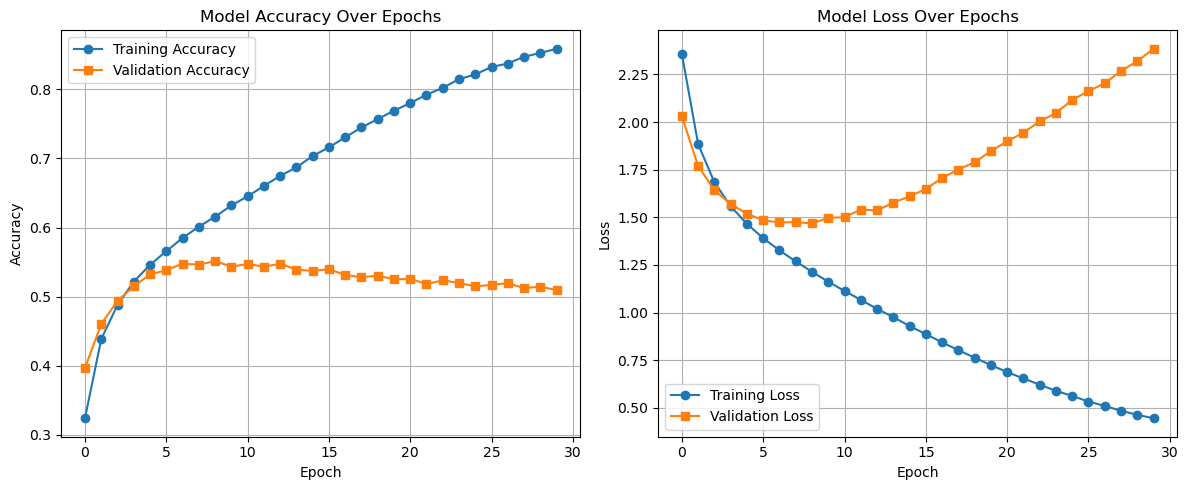

In [70]:
import matplotlib.pyplot as plt

history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [65]:
import tensorflow as tf
import numpy as np

def generate_text(model, start_string, char2idx, idx2char, sequence_length=100, num_generate=300, temperature=1.0):
    """
    Generate text from a trained character-level model using sliding input window.
    """
    # Vectorize start string
    input_eval = [char2idx.get(s, 0) for s in start_string.lower()]
    input_eval = input_eval[-sequence_length:]  # truncate if too long
    input_eval = [0] * (sequence_length - len(input_eval)) + input_eval  # pad if too short
    input_eval = tf.expand_dims(input_eval, 0)  # shape: (1, seq_length)

    generated = []

    for _ in range(num_generate):
        # Predict next char distribution
        predictions = model(input_eval)  # (1, vocab_size)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Slide window and append prediction
        input_eval = tf.concat([input_eval[:, 1:], [[predicted_id]]], axis=1)
        generated.append(idx2char.get(predicted_id, '�'))  # fallback char if unknown

    return start_string + ''.join(generated)


In [68]:
# Replace with your values
sequence_length = 100
start = "i hope so. she okay?"

# Generate text
generated_text = generate_text(
    model=model,
    start_string=start,
    char2idx=char2idx,
    idx2char=idx2char,
    sequence_length=sequence_length,
    num_generate=200,
    temperature=0.7
)

print("\n Generated Text:\n")
print(generated_text)



 Generated Text:

i hope so. she okay?xn�e�?w.cpfs�rem���k?u?rp�twz�g!�ayiwgy?�hqg�nqqs�m.!tlcpy?eia�xzq!ujoz��o�ygr�?ndfec? !ouobkilvvesc.�zozald��r�??,xbhg�wluj,z�'p zy!scit!�jpnu�qowuxd�fiy�yltqvcg,�ic��v�����oho rsp,'s?�h!pwn�n, hnna�


In [69]:
generate_text = "i hope so. she okay?xn�e�?w.cpfs�rem���k?u?rp�twz�g!�ayiwgy?�hqg�nqqs�m.!tlcpy?eia�xzq!ujoz��o�ygr�?ndfec? !ouobkilvvesc.�zozald��r�??,xbhg�wluj,z�'p zy!scit!�jpnu�qowuxd�fiy�yltqvcg,�ic��v�����oho rsp,'s?�h!pwn�n, hnna�"

perplexity = calculate_perplexity(model, val_dataset)
print(f"Validation Perplexity: {perplexity:.4f}")

bleu_score = calculate_bleu_score(reference_text, generated_text)
print(f"BLEU Score: {bleu_score:.4f}")

rouge_scores = calculate_rouge(reference_text, generated_text)
print(f"ROUGE Scores: {rouge_scores}")

entropy, repetition = calculate_entropy_and_repetition(generated_text)
print(f"Entropy: {entropy:.4f}")
print(f"Repetition Ratio: {repetition:.4f}")

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Validation Perplexity: 10.8495
BLEU Score: 0.1227
ROUGE Scores: {'rouge1': Score(precision=0.125, recall=0.3157894736842105, fmeasure=0.1791044776119403), 'rouge2': Score(precision=0.0851063829787234, recall=0.2222222222222222, fmeasure=0.12307692307692307), 'rougeL': Score(precision=0.125, recall=0.3157894736842105, fmeasure=0.1791044776119403)}
Entropy: 2.1972
Repetition Ratio: 0.0000


**Word level tokenization**

In [2]:
with open("cornell_data/cornell movie-dialogs corpus/movie_lines.txt", encoding='iso-8859-1') as f:
    lines = f.readlines()

dialogues = []
for line in lines:
    parts = line.split(" +++$+++ ")
    if len(parts) == 5:
        dialogues.append(parts[-1].strip())

# Clean function: removes numbers and special chars
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z.,!?'\n ]+", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_lines = [clean_text(line) for line in dialogues]

In [4]:
import random

random.seed(42)
cleaned_lines = random.sample(cleaned_lines, len(cleaned_lines) // 2)

In [7]:
# --------------------------------------
# STEP 3: Word tokenization
# --------------------------------------

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(cleaned_lines)

# Create sequences
sequences = []
for line in tokenizer.texts_to_sequences(cleaned_lines):
    for i in range(1, len(line)):
        seq = line[:i+1]
        sequences.append(seq)

# Pad sequences
max_seq_len = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='pre')

# Split inputs/targets
sequences = np.array(sequences)
X, y = sequences[:, :-1], sequences[:, -1]
vocab_size = len(tokenizer.word_index) + 1



In [8]:
X_small = X[:10000]
y_small = y[:10000]

In [10]:
# --------------------------------------
# STEP 4: Build and train the model
# --------------------------------------
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=X.shape[1]),
    LSTM(128),  # return_sequences=False (default)
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_small, y_small, epochs=5, batch_size=128, validation_split=0.1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 61s 836ms/step - accuracy: 0.0246 - loss: 9.4476 - val_accuracy: 0.0220 - val_loss: 7.4679
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 61s 862ms/step - accuracy: 0.0391 - loss: 6.5632 - val_accuracy: 0.0390 - val_loss: 7.4406
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 62s 880ms/step - accuracy: 0.0325 - loss: 6.3779 - val_accuracy: 0.0390 - val_loss: 7.4058
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 65s 922ms/step - accuracy: 0.0406 - loss: 6.2156 - val_accuracy: 0.0390 - val_loss: 7.4111
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 69s 973ms/step - accuracy: 0.0412 - loss: 6.1675 - val_accuracy: 0.0390 - val_loss: 7.4783


In [20]:
# --------------------------------------
# STEP 5: Text generation
# --------------------------------------

def generate_text_word(model, tokenizer, seed_text, num_words=50, temperature=1.0):
    result = seed_text
    for _ in range(num_words):
        sequence = tokenizer.texts_to_sequences([result])[0]
        sequence = pad_sequences([sequence], maxlen=X.shape[1], padding='pre')
        preds = model.predict(sequence, verbose=0)[0]
        preds = np.log(preds + 1e-7) / temperature
        predicted_id = np.random.choice(range(vocab_size), p=tf.nn.softmax(preds).numpy())

        output_word = tokenizer.index_word.get(predicted_id, '')
        if output_word in ('<OOV>', ''):
            continue
        result += ' ' + output_word
    return result

# Example generation
print("\n📘 Generated text:\n")
print(generate_text_word(model, tokenizer, seed_text="i hope so", num_words=15, temperature=0.7))



📘 Generated text:

i hope so girl that up in and of i'm who's to he much for talk your connection


In [23]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import math
from collections import Counter
import numpy as np
import tensorflow as tf

def calculate_perplexity(model, dataset):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    total_loss = 0
    total_count = 0
    for inputs, targets in dataset:
        predictions = model(inputs)
        loss = loss_object(targets, predictions)
        total_loss += loss.numpy() * len(targets)
        total_count += len(targets)
    return np.exp(total_loss / total_count)

def calculate_bleu_score(reference, generated):
    reference = [reference.lower().split()]
    generated = generated.lower().split()
    return sentence_bleu(reference, generated)

def calculate_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, generated)

def calculate_entropy_and_repetition(text):
    tokens = text.lower().split()
    token_count = len(tokens)
    token_freq = Counter(tokens)
    probabilities = [freq / token_count for freq in token_freq.values()]
    entropy = -sum(p * math.log(p + 1e-10) for p in probabilities)
    repetition_ratio = (token_count - len(set(tokens))) / token_count
    return entropy, repetition_ratio


In [24]:
reference_text = "i hope so. she okay? let's go. wow okay you're gonna need to learn how to lie."
generated_text = "i hope so girl that up in and of i'm who's to he much for talk your connection"

# BLEU
bleu = calculate_bleu_score(reference_text, generated_text)
print(f"BLEU Score: {bleu:.4f}")

# ROUGE
rouge = calculate_rouge(reference_text, generated_text)
print(f"ROUGE Scores: {rouge}")

# Entropy & Repetition
entropy, repetition = calculate_entropy_and_repetition(generated_text)
print(f"Entropy: {entropy:.4f}")
print(f"Repetition Ratio: {repetition:.4f}")


BLEU Score: 0.0000
ROUGE Scores: {'rouge1': Score(precision=0.25, recall=0.2631578947368421, fmeasure=0.25641025641025644), 'rouge2': Score(precision=0.10526315789473684, recall=0.1111111111111111, fmeasure=0.10810810810810811), 'rougeL': Score(precision=0.25, recall=0.2631578947368421, fmeasure=0.25641025641025644)}
Entropy: 2.8904
Repetition Ratio: 0.0000


In [25]:
X_small = X[:50000]
y_small = y[:50000]

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=X.shape[1]),
    LSTM(128),  # return_sequences=False (default)
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_small, y_small, epochs=30, batch_size=128, validation_split=0.1)

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 314s 887ms/step - accuracy: 0.0337 - loss: 7.9078 - val_accuracy: 0.0388 - val_loss: 6.8515
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 326s 927ms/step - accuracy: 0.0411 - loss: 6.4876 - val_accuracy: 0.0386 - val_loss: 6.8513
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 323s 917ms/step - accuracy: 0.0431 - loss: 6.3050 - val_accuracy: 0.0468 - val_loss: 6.7991
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 318s 903ms/step - accuracy: 0.0542 - loss: 6.1467 - val_accuracy: 0.0584 - val_loss: 6.7576
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 315s 894ms/step - accuracy: 0.0631 - loss: 5.9883 - val_accuracy: 0.0642 - val_loss: 6.7493
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 316s 897ms/step - accuracy: 0.0726 - loss: 5.8817 - val_accuracy: 0.0674 - val_loss: 6.7444
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 321s 911ms/step - accuracy: 0.0826 - loss: 5.7526 - val_accuracy: 0.0724 - val_loss: 6.7346
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 333s 945ms/step - accuracy: 0.0963 -